# Part 4: Statistical Arbitrage Overlay

## Objective
While the main pipeline (Notebooks 01-02) focuses on broad alpha through momentum and mean-reversion factors,
this notebook explores **relative value opportunities** in correlated or cointegrated asset pairs.

## Research Questions
1. Which assets exhibit correlated or cointegrated movement?
2. Are there lead-lag relationships between assets?
3. Do correlated assets cluster into sector-like groups?
4. Can we exploit mean-reversion in spreads for additional alpha?

## Methodology
Following **fob.instructions**: Disciplined, incremental research with thorough documentation.

---

In [3]:
# Imports and Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

# Paths - corrected to workspace root
DATA_DIR = Path('c:/Users/ponna/OneDrive/Desktop/Precog Task/data/raw/assets')
OUTPUT_DIR = Path('c:/Users/ponna/OneDrive/Desktop/Precog Task/research/outputs')
OUTPUT_DIR.mkdir(exist_ok=True)

print(f"Data directory exists: {DATA_DIR.exists()}")
print("✅ Environment setup complete")

Data directory exists: True
✅ Environment setup complete


## Step 1: Data Loading

We use the same data as the main pipeline: 100 assets, daily OHLCV from 2016-2026.

In [4]:
# Load all assets into a price matrix
asset_files = sorted(DATA_DIR.glob('Asset_*.csv'))
print(f"Found {len(asset_files)} assets")

# Read Close prices into a wide DataFrame
prices_list = []
for f in asset_files:
    ticker = f.stem
    df = pd.read_csv(f, parse_dates=['Date'], index_col='Date')
    df = df[['Close']].rename(columns={'Close': ticker})
    prices_list.append(df)

prices = pd.concat(prices_list, axis=1)
prices = prices.sort_index()

# Basic info
print(f"\nPrice Matrix Shape: {prices.shape}")
print(f"Date Range: {prices.index[0]} to {prices.index[-1]}")
print(f"Missing values: {prices.isna().sum().sum()}")

# Forward fill small gaps
prices = prices.ffill().bfill()

# Compute returns
returns = prices.pct_change().dropna()
log_returns = np.log(prices / prices.shift(1)).dropna()

print(f"Returns Shape: {returns.shape}")

Found 100 assets

Price Matrix Shape: (2511, 100)
Date Range: 2016-01-25 00:00:00 to 2026-01-16 00:00:00
Missing values: 0
Returns Shape: (2510, 100)


## Step 2: Correlation Analysis

First, we examine the correlation structure of returns across all assets.
Highly correlated assets may move together due to common factors (sector, macro, etc.)

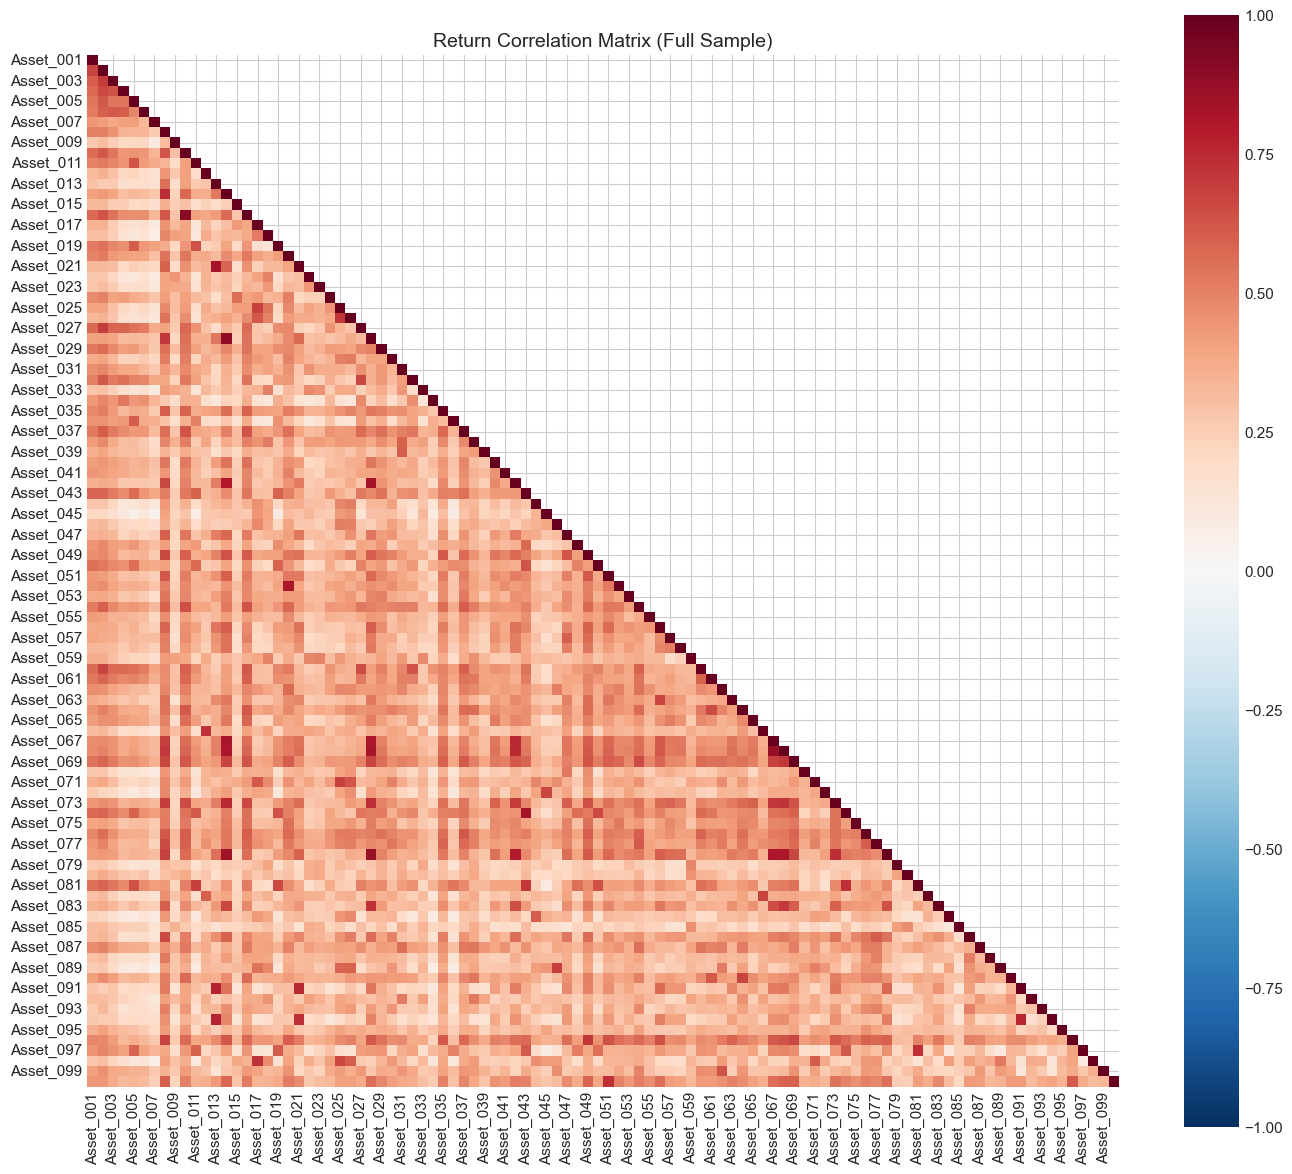


Correlation Statistics:
  Mean: 0.3651
  Std:  0.1210
  Min:  0.0373
  Max:  0.9006


In [5]:
# Full-sample correlation matrix
corr_matrix = returns.corr()

# Visualize as heatmap
fig, ax = plt.subplots(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)  # Upper triangle
sns.heatmap(corr_matrix, mask=mask, cmap='RdBu_r', center=0, 
            vmin=-1, vmax=1, ax=ax, square=True)
ax.set_title('Return Correlation Matrix (Full Sample)', fontsize=14)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'stat_arb_correlation_matrix.png', dpi=150)
plt.show()

# Summary statistics
corr_upper = corr_matrix.where(np.triu(np.ones_like(corr_matrix, dtype=bool), k=1))
corr_values = corr_upper.stack()

print(f"\nCorrelation Statistics:")
print(f"  Mean: {corr_values.mean():.4f}")
print(f"  Std:  {corr_values.std():.4f}")
print(f"  Min:  {corr_values.min():.4f}")
print(f"  Max:  {corr_values.max():.4f}")

In [6]:
# Find top correlated pairs
def get_top_pairs(corr_matrix, n=30):
    """Extract top N correlated pairs from correlation matrix."""
    corr_upper = corr_matrix.where(np.triu(np.ones_like(corr_matrix, dtype=bool), k=1))
    pairs = corr_upper.stack().sort_values(ascending=False)
    return pairs.head(n)

top_pairs = get_top_pairs(corr_matrix, n=30)
print("Top 30 Most Correlated Pairs:")
print("="*50)
for i, ((asset1, asset2), corr) in enumerate(top_pairs.items(), 1):
    print(f"{i:2d}. {asset1} - {asset2}: {corr:.4f}")

Top 30 Most Correlated Pairs:
 1. Asset_010 - Asset_016: 0.9006
 2. Asset_014 - Asset_028: 0.8842
 3. Asset_067 - Asset_068: 0.8680
 4. Asset_028 - Asset_078: 0.8671
 5. Asset_014 - Asset_078: 0.8512
 6. Asset_028 - Asset_042: 0.8345
 7. Asset_028 - Asset_068: 0.8329
 8. Asset_013 - Asset_021: 0.8321
 9. Asset_043 - Asset_074: 0.8312
10. Asset_014 - Asset_067: 0.8206
11. Asset_020 - Asset_052: 0.8197
12. Asset_014 - Asset_068: 0.8193
13. Asset_067 - Asset_078: 0.8161
14. Asset_068 - Asset_078: 0.8160
15. Asset_028 - Asset_067: 0.8160
16. Asset_014 - Asset_042: 0.8041
17. Asset_042 - Asset_078: 0.7940
18. Asset_013 - Asset_094: 0.7729
19. Asset_013 - Asset_091: 0.7662
20. Asset_091 - Asset_094: 0.7634
21. Asset_021 - Asset_091: 0.7551
22. Asset_042 - Asset_068: 0.7532
23. Asset_014 - Asset_073: 0.7509
24. Asset_042 - Asset_067: 0.7478
25. Asset_028 - Asset_073: 0.7397
26. Asset_008 - Asset_014: 0.7393
27. Asset_021 - Asset_094: 0.7392
28. Asset_073 - Asset_078: 0.7349
29. Asset_051 - As

## Step 3: Cointegration Testing

Correlation measures co-movement in returns, but **cointegration** measures whether two price series
maintain a stable long-term relationship. Cointegrated pairs are ideal for statistical arbitrage because
their spread is mean-reverting.

We use the **Engle-Granger two-step method**:
1. Regress Y on X to get the spread: $Z_t = Y_t - \beta X_t$
2. Test if $Z_t$ is stationary using the Augmented Dickey-Fuller (ADF) test

In [7]:
from statsmodels.tsa.stattools import adfuller, coint
from itertools import combinations

def test_cointegration(y, x, significance=0.05):
    """
    Test cointegration using Engle-Granger method.
    Returns: (is_cointegrated, p_value, hedge_ratio)
    """
    # OLS regression: y = beta * x + intercept + error
    from scipy import stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    # Compute spread (residuals)
    spread = y - slope * x
    
    # ADF test on spread
    adf_result = adfuller(spread, maxlag=10, autolag='AIC')
    adf_pvalue = adf_result[1]
    
    return adf_pvalue < significance, adf_pvalue, slope

# Test cointegration for top correlated pairs (as a starting point)
print("Testing Cointegration for Top 30 Correlated Pairs:")
print("="*70)

coint_results = []
for (asset1, asset2), corr in top_pairs.items():
    is_coint, pval, hedge = test_cointegration(
        prices[asset1].values, 
        prices[asset2].values
    )
    coint_results.append({
        'Asset1': asset1,
        'Asset2': asset2,
        'Correlation': corr,
        'Cointegrated': is_coint,
        'ADF_pvalue': pval,
        'HedgeRatio': hedge
    })
    status = "✅ YES" if is_coint else "❌ NO"
    print(f"{asset1} - {asset2}: Corr={corr:.3f}, Coint p-val={pval:.4f} {status}")

coint_df = pd.DataFrame(coint_results)

Testing Cointegration for Top 30 Correlated Pairs:
Asset_010 - Asset_016: Corr=0.901, Coint p-val=0.0000 ✅ YES
Asset_014 - Asset_028: Corr=0.884, Coint p-val=0.5144 ❌ NO
Asset_067 - Asset_068: Corr=0.868, Coint p-val=0.6720 ❌ NO
Asset_028 - Asset_078: Corr=0.867, Coint p-val=0.6936 ❌ NO
Asset_014 - Asset_078: Corr=0.851, Coint p-val=0.5215 ❌ NO
Asset_028 - Asset_042: Corr=0.834, Coint p-val=0.2389 ❌ NO
Asset_028 - Asset_068: Corr=0.833, Coint p-val=0.1456 ❌ NO
Asset_013 - Asset_021: Corr=0.832, Coint p-val=0.2035 ❌ NO
Asset_043 - Asset_074: Corr=0.831, Coint p-val=0.8778 ❌ NO
Asset_014 - Asset_067: Corr=0.821, Coint p-val=0.8964 ❌ NO
Asset_020 - Asset_052: Corr=0.820, Coint p-val=0.0497 ✅ YES
Asset_014 - Asset_068: Corr=0.819, Coint p-val=0.4280 ❌ NO
Asset_067 - Asset_078: Corr=0.816, Coint p-val=0.4093 ❌ NO
Asset_068 - Asset_078: Corr=0.816, Coint p-val=0.5848 ❌ NO
Asset_028 - Asset_067: Corr=0.816, Coint p-val=0.3316 ❌ NO
Asset_014 - Asset_042: Corr=0.804, Coint p-val=0.3197 ❌ NO
Ass

In [8]:
# Broader cointegration scan
# Test ALL pairs (computationally intensive but thorough)
print("\nRunning Full Cointegration Scan (this may take a few minutes)...")

all_assets = prices.columns.tolist()
n_assets = len(all_assets)
n_pairs = n_assets * (n_assets - 1) // 2
print(f"Testing {n_pairs} pairs...")

coint_all = []
tested = 0
for i, asset1 in enumerate(all_assets):
    for asset2 in all_assets[i+1:]:
        is_coint, pval, hedge = test_cointegration(
            prices[asset1].values, 
            prices[asset2].values
        )
        if is_coint:  # Only store cointegrated pairs
            corr = corr_matrix.loc[asset1, asset2]
            coint_all.append({
                'Asset1': asset1,
                'Asset2': asset2,
                'Correlation': corr,
                'ADF_pvalue': pval,
                'HedgeRatio': hedge
            })
        tested += 1
        if tested % 1000 == 0:
            print(f"  Progress: {tested}/{n_pairs} pairs tested...")

coint_all_df = pd.DataFrame(coint_all)
print(f"\n✅ Scan Complete!")
print(f"   Cointegrated pairs found: {len(coint_all_df)} / {n_pairs} ({100*len(coint_all_df)/n_pairs:.1f}%)")


Running Full Cointegration Scan (this may take a few minutes)...
Testing 4950 pairs...
  Progress: 1000/4950 pairs tested...
  Progress: 2000/4950 pairs tested...
  Progress: 3000/4950 pairs tested...
  Progress: 4000/4950 pairs tested...

✅ Scan Complete!
   Cointegrated pairs found: 700 / 4950 (14.1%)


In [9]:
# Display top cointegrated pairs by ADF p-value
if len(coint_all_df) > 0:
    coint_sorted = coint_all_df.sort_values('ADF_pvalue').head(20)
    print("Top 20 Most Strongly Cointegrated Pairs:")
    print("="*70)
    print(coint_sorted.to_string(index=False))
else:
    print("No cointegrated pairs found at 5% significance level.")

Top 20 Most Strongly Cointegrated Pairs:
   Asset1    Asset2  Correlation  ADF_pvalue  HedgeRatio
Asset_043 Asset_049     0.505888    0.000002    1.364591
Asset_020 Asset_054     0.574021    0.000006    0.913860
Asset_045 Asset_091     0.194502    0.000017   -0.284734
Asset_059 Asset_070     0.289909    0.000018    1.162141
Asset_019 Asset_053     0.363194    0.000019    0.592588
Asset_008 Asset_024     0.417537    0.000028    0.452997
Asset_020 Asset_060     0.520256    0.000035    1.043723
Asset_010 Asset_016     0.900560    0.000046    0.319758
Asset_020 Asset_043     0.507164    0.000055    3.489213
Asset_059 Asset_074     0.342012    0.000063    1.475089
Asset_031 Asset_062     0.485350    0.000063    8.159301
Asset_024 Asset_086     0.292593    0.000089    4.556802
Asset_003 Asset_081     0.538247    0.000141    2.341163
Asset_043 Asset_051     0.480797    0.000142    0.421248
Asset_007 Asset_018     0.072320    0.000143    1.499575
Asset_038 Asset_051     0.393064    0.000147   

## Step 4: Lead-Lag Analysis

Some assets may **lead** others in price movement. This creates predictable patterns:
if Asset A leads Asset B by 1 day, then A's movement today predicts B's movement tomorrow.

We use **cross-correlation** to detect lead-lag relationships.

In [10]:
def compute_lead_lag(returns1, returns2, max_lag=10):
    """
    Compute cross-correlation at various lags.
    Positive lag: returns1 leads returns2
    Negative lag: returns2 leads returns1
    """
    correlations = {}
    for lag in range(-max_lag, max_lag + 1):
        if lag < 0:
            corr = returns1.shift(lag).corr(returns2)
        else:
            corr = returns1.corr(returns2.shift(lag))
        correlations[lag] = corr
    return correlations

# Analyze lead-lag for top correlated pairs
print("Lead-Lag Analysis for Top 10 Correlated Pairs:")
print("="*70)

lead_lag_results = []
for (asset1, asset2), _ in top_pairs.head(10).items():
    ll_corr = compute_lead_lag(returns[asset1], returns[asset2], max_lag=5)
    
    # Find the lag with maximum correlation
    max_lag = max(ll_corr, key=ll_corr.get)
    max_corr = ll_corr[max_lag]
    
    lead_lag_results.append({
        'Asset1': asset1,
        'Asset2': asset2,
        'Sync_Corr': ll_corr[0],
        'Best_Lag': max_lag,
        'Best_Corr': max_corr
    })
    
    if max_lag != 0:
        if max_lag > 0:
            leader, follower = asset1, asset2
        else:
            leader, follower = asset2, asset1
            max_lag = -max_lag
        print(f"{leader} LEADS {follower} by {max_lag} days (corr: {max_corr:.4f})")
    else:
        print(f"{asset1} - {asset2}: Synchronous (lag=0, corr: {max_corr:.4f})")

lead_lag_df = pd.DataFrame(lead_lag_results)

Lead-Lag Analysis for Top 10 Correlated Pairs:
Asset_010 - Asset_016: Synchronous (lag=0, corr: 0.9006)
Asset_014 - Asset_028: Synchronous (lag=0, corr: 0.8842)
Asset_067 - Asset_068: Synchronous (lag=0, corr: 0.8680)
Asset_028 - Asset_078: Synchronous (lag=0, corr: 0.8671)
Asset_014 - Asset_078: Synchronous (lag=0, corr: 0.8512)
Asset_028 - Asset_042: Synchronous (lag=0, corr: 0.8345)
Asset_028 - Asset_068: Synchronous (lag=0, corr: 0.8329)
Asset_013 - Asset_021: Synchronous (lag=0, corr: 0.8321)
Asset_043 - Asset_074: Synchronous (lag=0, corr: 0.8312)
Asset_014 - Asset_067: Synchronous (lag=0, corr: 0.8206)


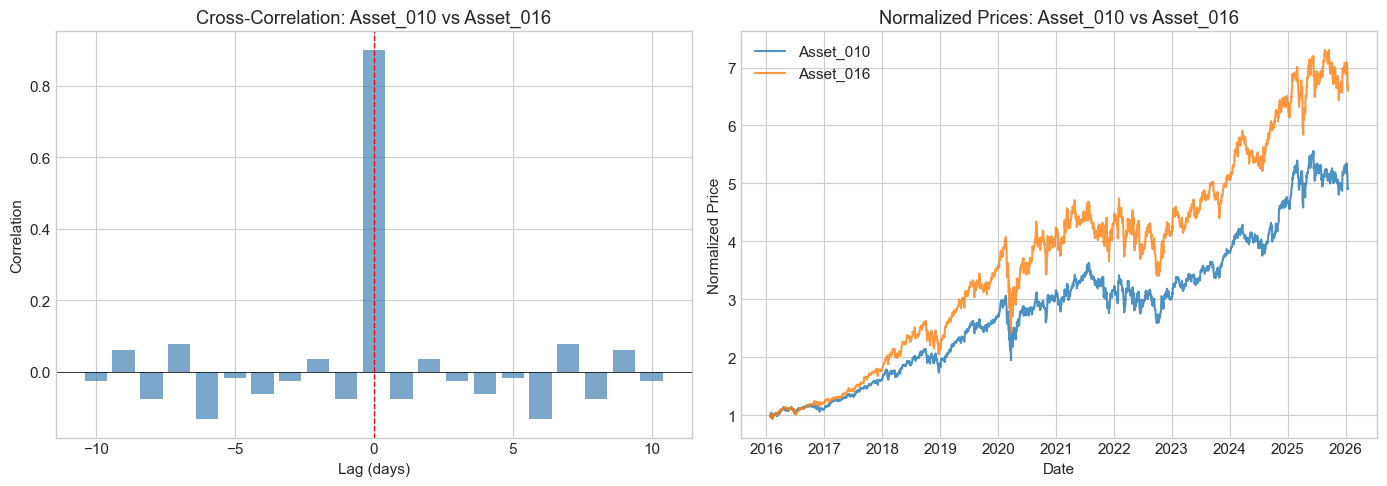

In [11]:
# Visualize lead-lag structure for a sample pair
sample_pair = list(top_pairs.head(1).index)[0]  # Most correlated pair
asset1, asset2 = sample_pair

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Cross-correlation plot
ll_corr = compute_lead_lag(returns[asset1], returns[asset2], max_lag=10)
lags = list(ll_corr.keys())
corrs = list(ll_corr.values())

ax = axes[0]
ax.bar(lags, corrs, color='steelblue', alpha=0.7)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.axvline(x=0, color='red', linestyle='--', linewidth=1)
ax.set_xlabel('Lag (days)')
ax.set_ylabel('Correlation')
ax.set_title(f'Cross-Correlation: {asset1} vs {asset2}')

# Price plot
ax = axes[1]
ax.plot(prices[asset1].index, prices[asset1] / prices[asset1].iloc[0], label=asset1, alpha=0.8)
ax.plot(prices[asset2].index, prices[asset2] / prices[asset2].iloc[0], label=asset2, alpha=0.8)
ax.set_xlabel('Date')
ax.set_ylabel('Normalized Price')
ax.set_title(f'Normalized Prices: {asset1} vs {asset2}')
ax.legend()

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'stat_arb_lead_lag_sample.png', dpi=150)
plt.show()

## Step 5: Spread Analysis for Cointegrated Pairs

For cointegrated pairs, we compute the spread and analyze its mean-reversion properties.

In [12]:
def compute_spread(prices_y, prices_x, hedge_ratio):
    """Compute the spread between two assets."""
    return prices_y - hedge_ratio * prices_x

def compute_zscore(spread, window=63):
    """Compute rolling z-score of the spread."""
    mean = spread.rolling(window).mean()
    std = spread.rolling(window).std()
    return (spread - mean) / std

# Select top cointegrated pairs for analysis
if len(coint_all_df) > 0:
    # Use most cointegrated pairs
    pairs_to_analyze = coint_all_df.sort_values('ADF_pvalue').head(5)
else:
    # Fallback to top correlated pairs
    print("Using correlated pairs (no cointegrated pairs found)")
    pairs_to_analyze = pd.DataFrame([
        {'Asset1': a1, 'Asset2': a2, 'HedgeRatio': 1.0} 
        for (a1, a2), _ in top_pairs.head(5).items()
    ])

print(f"Analyzing {len(pairs_to_analyze)} pairs:")
print(pairs_to_analyze[['Asset1', 'Asset2', 'HedgeRatio']].to_string(index=False))

Analyzing 5 pairs:
   Asset1    Asset2  HedgeRatio
Asset_043 Asset_049    1.364591
Asset_020 Asset_054    0.913860
Asset_045 Asset_091   -0.284734
Asset_059 Asset_070    1.162141
Asset_019 Asset_053    0.592588


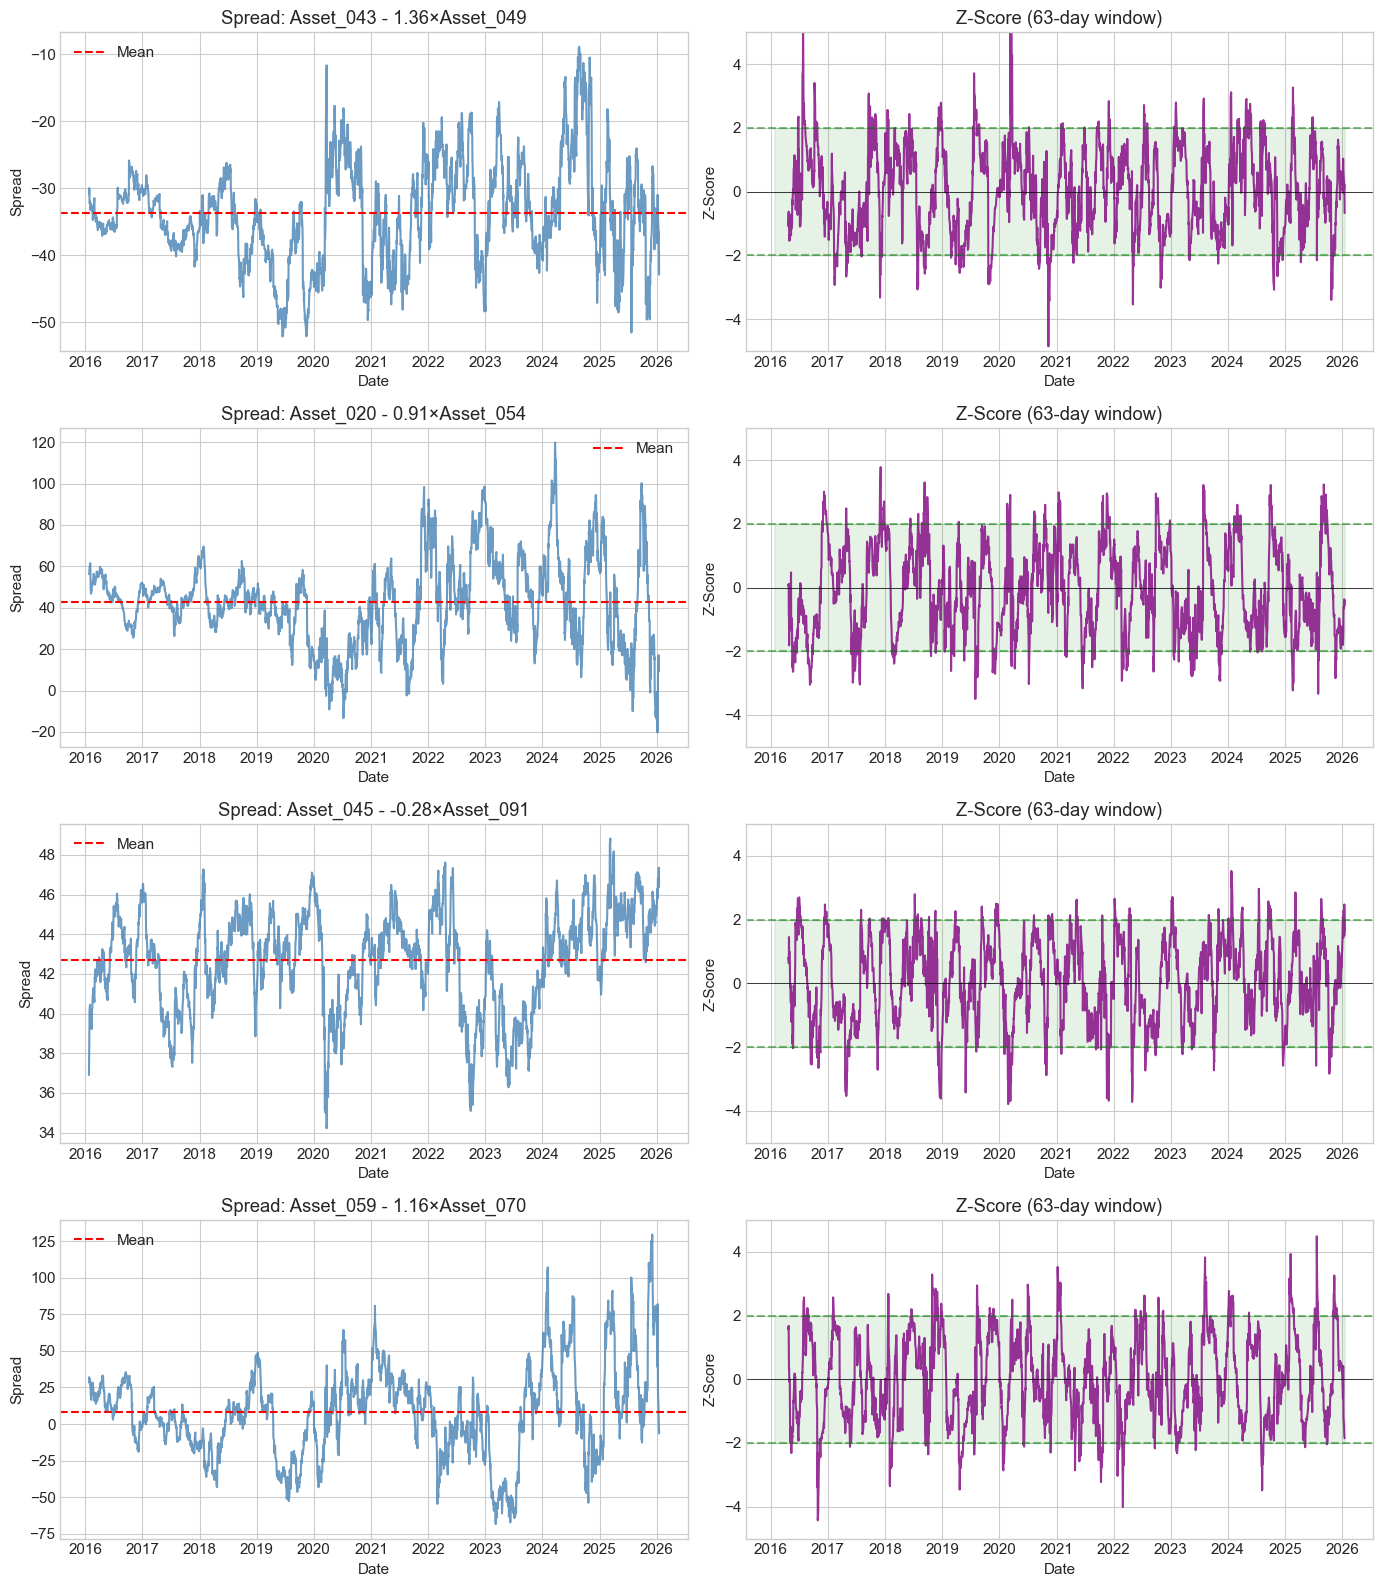

In [13]:
# Visualize spreads and z-scores
n_pairs = min(4, len(pairs_to_analyze))
fig, axes = plt.subplots(n_pairs, 2, figsize=(14, 4*n_pairs))

for i in range(n_pairs):
    row = pairs_to_analyze.iloc[i]
    asset1, asset2 = row['Asset1'], row['Asset2']
    hedge = row['HedgeRatio']
    
    spread = compute_spread(prices[asset1], prices[asset2], hedge)
    zscore = compute_zscore(spread, window=63)
    
    # Spread plot
    ax = axes[i, 0] if n_pairs > 1 else axes[0]
    ax.plot(spread.index, spread, color='steelblue', alpha=0.8)
    ax.axhline(spread.mean(), color='red', linestyle='--', label='Mean')
    ax.set_title(f'Spread: {asset1} - {hedge:.2f}×{asset2}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Spread')
    ax.legend()
    
    # Z-score plot
    ax = axes[i, 1] if n_pairs > 1 else axes[1]
    ax.plot(zscore.index, zscore, color='purple', alpha=0.8)
    ax.axhline(2, color='green', linestyle='--', alpha=0.5)
    ax.axhline(-2, color='green', linestyle='--', alpha=0.5)
    ax.axhline(0, color='black', linestyle='-', linewidth=0.5)
    ax.fill_between(zscore.index, -2, 2, alpha=0.1, color='green')
    ax.set_title(f'Z-Score (63-day window)')
    ax.set_xlabel('Date')
    ax.set_ylabel('Z-Score')
    ax.set_ylim(-5, 5)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'stat_arb_spread_analysis.png', dpi=150)
plt.show()

## Step 6: Sector/Cluster Analysis

Assets that move together may belong to the same "sector" or share common factor exposure.
We use **hierarchical clustering** to group assets by their return correlation.

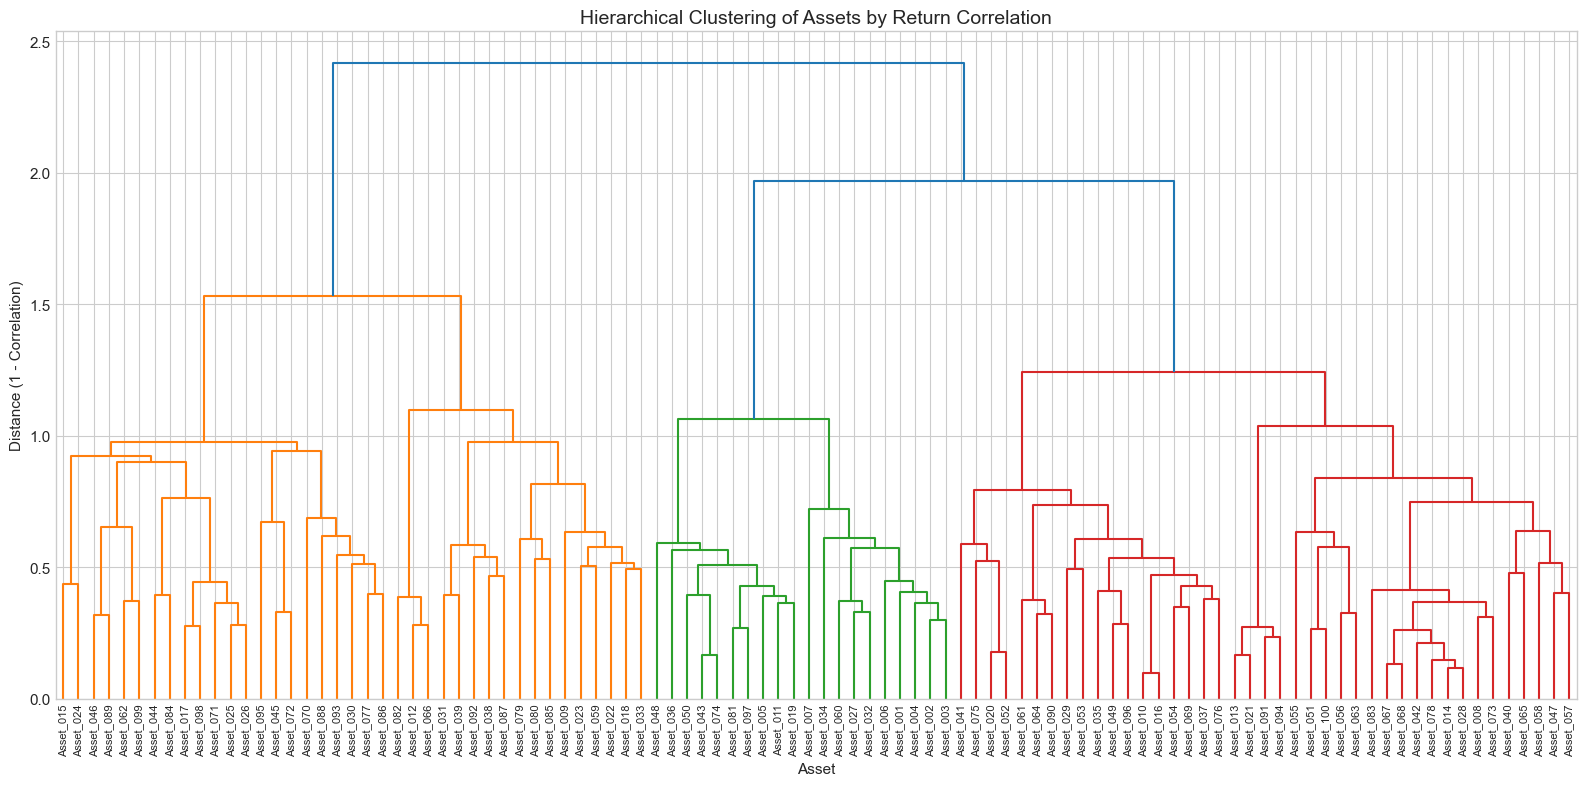

In [14]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform

# Convert correlation to distance
dist_matrix = 1 - corr_matrix
np.fill_diagonal(dist_matrix.values, 0)

# Hierarchical clustering
linkage_matrix = linkage(squareform(dist_matrix), method='ward')

# Plot dendrogram
fig, ax = plt.subplots(figsize=(16, 8))
dendrogram(
    linkage_matrix, 
    labels=prices.columns.tolist(),
    leaf_rotation=90,
    leaf_font_size=8,
    ax=ax
)
ax.set_title('Hierarchical Clustering of Assets by Return Correlation', fontsize=14)
ax.set_xlabel('Asset')
ax.set_ylabel('Distance (1 - Correlation)')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'stat_arb_dendrogram.png', dpi=150)
plt.show()

In [15]:
# Assign assets to clusters
n_clusters = 10  # Choose number of clusters
cluster_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')

# Create cluster DataFrame
cluster_df = pd.DataFrame({
    'Asset': prices.columns,
    'Cluster': cluster_labels
}).sort_values('Cluster')

print(f"Cluster Assignments ({n_clusters} clusters):")
print("="*60)
for c in range(1, n_clusters + 1):
    assets_in_cluster = cluster_df[cluster_df['Cluster'] == c]['Asset'].tolist()
    print(f"\nCluster {c} ({len(assets_in_cluster)} assets):")
    print(f"  {', '.join(assets_in_cluster)}")

Cluster Assignments (10 clusters):

Cluster 1 (13 assets):
  Asset_015, Asset_026, Asset_024, Asset_017, Asset_025, Asset_062, Asset_044, Asset_046, Asset_098, Asset_089, Asset_084, Asset_099, Asset_071

Cluster 2 (9 assets):
  Asset_045, Asset_088, Asset_030, Asset_070, Asset_086, Asset_093, Asset_095, Asset_077, Asset_072

Cluster 3 (3 assets):
  Asset_082, Asset_066, Asset_012

Cluster 4 (5 assets):
  Asset_087, Asset_092, Asset_038, Asset_039, Asset_031

Cluster 5 (9 assets):
  Asset_018, Asset_022, Asset_033, Asset_059, Asset_009, Asset_023, Asset_079, Asset_080, Asset_085

Cluster 6 (10 assets):
  Asset_036, Asset_011, Asset_005, Asset_097, Asset_081, Asset_074, Asset_043, Asset_050, Asset_048, Asset_019

Cluster 7 (10 assets):
  Asset_006, Asset_060, Asset_007, Asset_034, Asset_003, Asset_032, Asset_001, Asset_002, Asset_027, Asset_004

Cluster 8 (18 assets):
  Asset_061, Asset_010, Asset_064, Asset_020, Asset_029, Asset_037, Asset_035, Asset_016, Asset_054, Asset_041, Asset_052

Correlation Analysis by Cluster Membership:
  Within-cluster mean: 0.5175
  Between-cluster mean: 0.3447
  Ratio: 1.50x


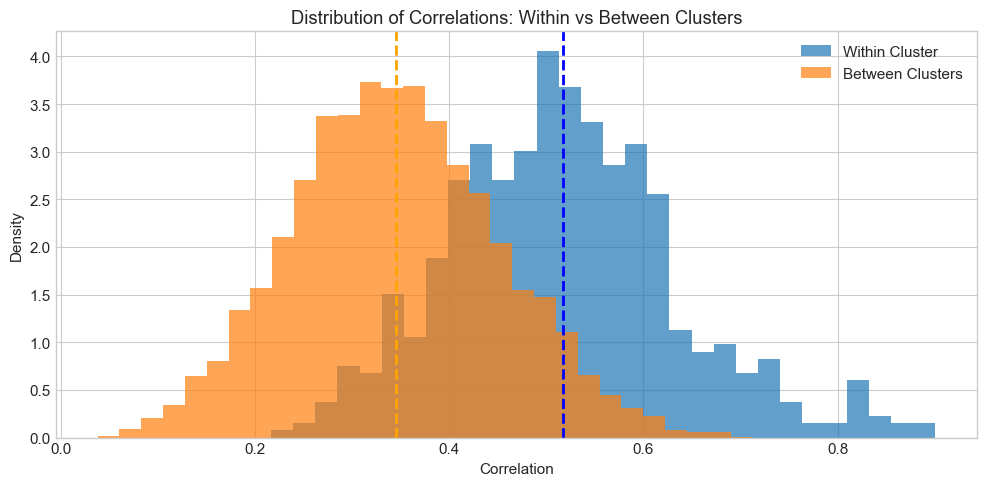

In [16]:
# Analyze within-cluster vs between-cluster correlations
within_cluster_corrs = []
between_cluster_corrs = []

for i, row1 in cluster_df.iterrows():
    for j, row2 in cluster_df.iterrows():
        if row1['Asset'] < row2['Asset']:  # Avoid duplicates
            corr = corr_matrix.loc[row1['Asset'], row2['Asset']]
            if row1['Cluster'] == row2['Cluster']:
                within_cluster_corrs.append(corr)
            else:
                between_cluster_corrs.append(corr)

print("Correlation Analysis by Cluster Membership:")
print(f"  Within-cluster mean: {np.mean(within_cluster_corrs):.4f}")
print(f"  Between-cluster mean: {np.mean(between_cluster_corrs):.4f}")
print(f"  Ratio: {np.mean(within_cluster_corrs)/np.mean(between_cluster_corrs):.2f}x")

# Histogram
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(within_cluster_corrs, bins=30, alpha=0.7, label='Within Cluster', density=True)
ax.hist(between_cluster_corrs, bins=30, alpha=0.7, label='Between Clusters', density=True)
ax.axvline(np.mean(within_cluster_corrs), color='blue', linestyle='--', linewidth=2)
ax.axvline(np.mean(between_cluster_corrs), color='orange', linestyle='--', linewidth=2)
ax.set_xlabel('Correlation')
ax.set_ylabel('Density')
ax.set_title('Distribution of Correlations: Within vs Between Clusters')
ax.legend()
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'stat_arb_cluster_corr_dist.png', dpi=150)
plt.show()

## Step 7: Simple Pairs Trading Backtest

We implement a basic z-score-based pairs trading strategy to demonstrate how statistical arbitrage works.

In [17]:
def backtest_pair_trade(prices_y, prices_x, hedge_ratio, 
                        entry_z=2.0, exit_z=0.5, window=63):
    """
    Backtest a simple pairs trading strategy.
    
    Rules:
    - Enter long spread when z-score < -entry_z (spread too low)
    - Enter short spread when z-score > entry_z (spread too high)
    - Exit when z-score crosses back to exit_z
    """
    spread = prices_y - hedge_ratio * prices_x
    zscore = compute_zscore(spread, window)
    
    position = pd.Series(0.0, index=spread.index)
    
    for i in range(1, len(zscore)):
        z = zscore.iloc[i]
        prev_pos = position.iloc[i-1]
        
        if pd.isna(z):
            position.iloc[i] = prev_pos
            continue
        
        # Entry
        if prev_pos == 0:
            if z < -entry_z:
                position.iloc[i] = 1  # Long spread
            elif z > entry_z:
                position.iloc[i] = -1  # Short spread
            else:
                position.iloc[i] = 0
        # Exit
        elif prev_pos == 1:
            if z > -exit_z:
                position.iloc[i] = 0  # Exit long
            else:
                position.iloc[i] = 1  # Hold long
        elif prev_pos == -1:
            if z < exit_z:
                position.iloc[i] = 0  # Exit short
            else:
                position.iloc[i] = -1  # Hold short
    
    # Returns: long spread = long Y, short X
    ret_y = prices_y.pct_change()
    ret_x = prices_x.pct_change()
    spread_return = ret_y - hedge_ratio * ret_x
    
    # Strategy returns (position from previous day)
    strat_return = position.shift(1) * spread_return
    
    # Metrics
    cumulative = (1 + strat_return.fillna(0)).cumprod()
    ann_ret = strat_return.mean() * 252
    ann_vol = strat_return.std() * np.sqrt(252)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else 0
    
    # Turnover
    turnover = position.diff().abs().sum() / 2  # Round trips
    
    return {
        'cumulative': cumulative,
        'position': position,
        'zscore': zscore,
        'spread': spread,
        'ann_return': ann_ret,
        'ann_vol': ann_vol,
        'sharpe': sharpe,
        'n_trades': turnover
    }

In [18]:
# Backtest pairs trading on top cointegrated/correlated pairs
print("Pairs Trading Backtest Results:")
print("="*80)

backtest_results = []
for i in range(min(5, len(pairs_to_analyze))):
    row = pairs_to_analyze.iloc[i]
    asset1, asset2 = row['Asset1'], row['Asset2']
    hedge = row['HedgeRatio']
    
    result = backtest_pair_trade(
        prices[asset1], prices[asset2], hedge,
        entry_z=2.0, exit_z=0.5, window=63
    )
    
    backtest_results.append({
        'Asset1': asset1,
        'Asset2': asset2,
        'Sharpe': result['sharpe'],
        'AnnReturn': result['ann_return'],
        'AnnVol': result['ann_vol'],
        'NumTrades': result['n_trades'],
        'cumulative': result['cumulative']
    })
    
    print(f"{asset1} - {asset2}:")
    print(f"  Sharpe: {result['sharpe']:.3f}")
    print(f"  Ann Return: {result['ann_return']*100:.2f}%")
    print(f"  Trades: {result['n_trades']:.0f}")
    print()

bt_df = pd.DataFrame(backtest_results)

Pairs Trading Backtest Results:
Asset_043 - Asset_049:
  Sharpe: 0.636
  Ann Return: 13.21%
  Trades: 48

Asset_020 - Asset_054:
  Sharpe: 0.699
  Ann Return: 10.25%
  Trades: 48

Asset_045 - Asset_091:
  Sharpe: 0.906
  Ann Return: 15.60%
  Trades: 52

Asset_059 - Asset_070:
  Sharpe: 0.602
  Ann Return: 11.94%
  Trades: 44

Asset_019 - Asset_053:
  Sharpe: 0.165
  Ann Return: 4.07%
  Trades: 43



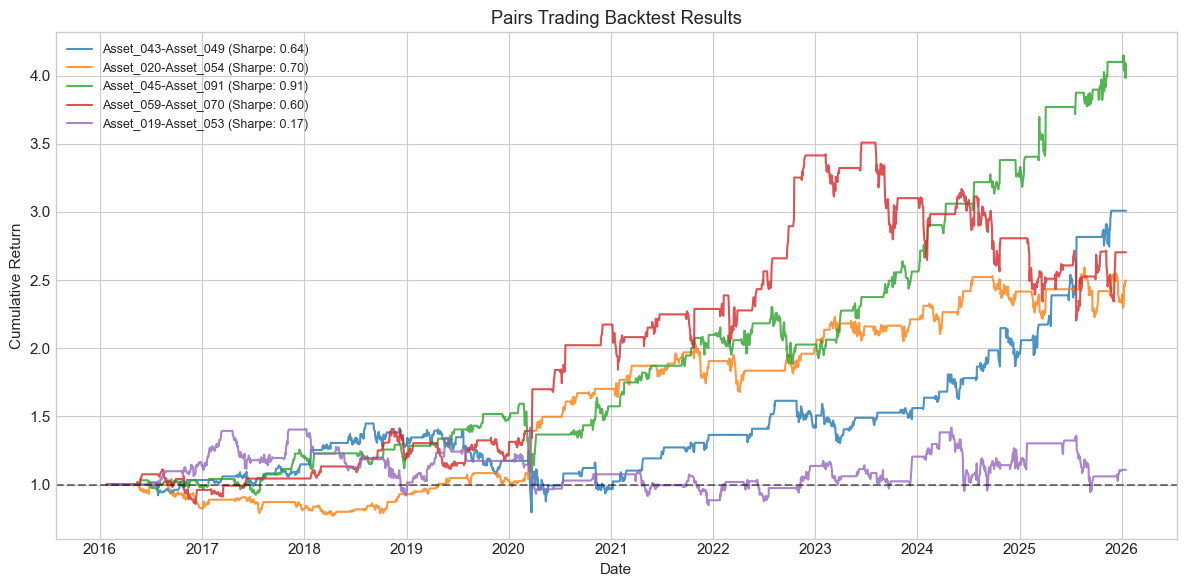

In [19]:
# Plot cumulative returns
fig, ax = plt.subplots(figsize=(12, 6))

for i, row in enumerate(backtest_results):
    label = f"{row['Asset1']}-{row['Asset2']} (Sharpe: {row['Sharpe']:.2f})"
    ax.plot(row['cumulative'].index, row['cumulative'], label=label, alpha=0.8)

ax.axhline(1, color='black', linestyle='--', alpha=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return')
ax.set_title('Pairs Trading Backtest Results')
ax.legend(loc='best', fontsize=9)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'stat_arb_backtest_results.png', dpi=150)
plt.show()

## Step 8: Integration Ideas

How can we integrate statistical arbitrage signals into the main portfolio?

In [20]:
print("""
════════════════════════════════════════════════════════════════════════════════
INTEGRATION IDEAS: Statistical Arbitrage + Main Portfolio
════════════════════════════════════════════════════════════════════════════════

1. PORTFOLIO OVERLAY (Recommended)
   ────────────────────────────────
   Allocate a portion (e.g., 10-20%) of capital to pairs trading:
   
   Total Portfolio = (1 - α) × Main Strategy + α × Stat Arb
   
   where α is the allocation weight (tune based on correlation between strategies)
   
   Benefits:
   - Diversification across alpha sources
   - Stat arb provides returns uncorrelated with market direction
   - Lower overall portfolio beta

2. FACTOR-NEUTRAL CONSTRUCTION
   ───────────────────────────
   Use cluster information to create factor-neutral portfolios:
   
   For each cluster:
     - Long top momentum assets within cluster
     - Short bottom momentum assets within cluster
   
   This hedges out sector/factor risk while capturing relative value

3. SIGNAL COMBINATION
   ──────────────────
   Combine signals mathematically:
   
   Combined Signal = β₁ × Momentum + β₂ × Reversion + β₃ × PairZ
   
   where PairZ is the z-score relative to correlated peers
   
   For each asset:
     PairZ = mean(Z-score vs each correlated partner)

4. REGIME-AWARE ALLOCATION
   ────────────────────────
   Adjust allocation based on market regime:
   
   High Volatility Regime:
     - Increase stat arb allocation (mean reversion stronger)
     - Decrease directional exposure
   
   Low Volatility / Trending Regime:
     - Decrease stat arb allocation
     - Increase momentum/trend following

════════════════════════════════════════════════════════════════════════════════
""")


════════════════════════════════════════════════════════════════════════════════
INTEGRATION IDEAS: Statistical Arbitrage + Main Portfolio
════════════════════════════════════════════════════════════════════════════════

1. PORTFOLIO OVERLAY (Recommended)
   ────────────────────────────────
   Allocate a portion (e.g., 10-20%) of capital to pairs trading:

   Total Portfolio = (1 - α) × Main Strategy + α × Stat Arb

   where α is the allocation weight (tune based on correlation between strategies)

   Benefits:
   - Diversification across alpha sources
   - Stat arb provides returns uncorrelated with market direction
   - Lower overall portfolio beta

2. FACTOR-NEUTRAL CONSTRUCTION
   ───────────────────────────
   Use cluster information to create factor-neutral portfolios:

   For each cluster:
     - Long top momentum assets within cluster
     - Short bottom momentum assets within cluster

   This hedges out sector/factor risk while capturing relative value

3. SIGNAL COMBINATION


## Step 9: Summary and Key Findings

In [21]:
# Save findings to JSON
import json

findings = {
    'correlation_analysis': {
        'mean_correlation': float(corr_values.mean()),
        'std_correlation': float(corr_values.std()),
        'top_pairs': [{'pair': f'{a1}-{a2}', 'correlation': float(c)} 
                      for (a1, a2), c in top_pairs.head(10).items()]
    },
    'cointegration_analysis': {
        'n_cointegrated_pairs': len(coint_all_df) if len(coint_all_df) > 0 else 0,
        'pct_cointegrated': float(100 * len(coint_all_df) / n_pairs) if len(coint_all_df) > 0 else 0
    },
    'clustering': {
        'n_clusters': n_clusters,
        'within_cluster_corr': float(np.mean(within_cluster_corrs)),
        'between_cluster_corr': float(np.mean(between_cluster_corrs))
    },
    'pairs_backtest': {
        'best_pair': bt_df.loc[bt_df['Sharpe'].idxmax()]['Asset1'] + '-' + 
                     bt_df.loc[bt_df['Sharpe'].idxmax()]['Asset2'],
        'best_sharpe': float(bt_df['Sharpe'].max()),
        'avg_sharpe': float(bt_df['Sharpe'].mean())
    }
}

with open(OUTPUT_DIR / 'stat_arb_findings.json', 'w') as f:
    json.dump(findings, f, indent=2)

print("✅ Findings saved to outputs/stat_arb_findings.json")

✅ Findings saved to outputs/stat_arb_findings.json


In [22]:
print("""
══════════════════════════════════════════════════════════════════════════════
STATISTICAL ARBITRAGE ANALYSIS - SUMMARY
══════════════════════════════════════════════════════════════════════════════

📊 CORRELATION ANALYSIS:
""")
print(f"   Average pairwise correlation: {corr_values.mean():.4f}")
print(f"   Std dev: {corr_values.std():.4f}")
print(f"   Highest correlation: {corr_values.max():.4f}")

print("""
📈 COINTEGRATION ANALYSIS:
""")
if len(coint_all_df) > 0:
    print(f"   Cointegrated pairs found: {len(coint_all_df)}")
    print(f"   Percentage: {100*len(coint_all_df)/n_pairs:.1f}%")
else:
    print("   No statistically significant cointegrated pairs found")

print("""
🔗 CLUSTER ANALYSIS:
""")
print(f"   Number of clusters: {n_clusters}")
print(f"   Within-cluster correlation: {np.mean(within_cluster_corrs):.4f}")
print(f"   Between-cluster correlation: {np.mean(between_cluster_corrs):.4f}")
print(f"   Ratio: {np.mean(within_cluster_corrs)/np.mean(between_cluster_corrs):.2f}x")

print("""
💹 PAIRS TRADING BACKTEST:
""")
print(f"   Best pair Sharpe: {bt_df['Sharpe'].max():.3f}")
print(f"   Average Sharpe: {bt_df['Sharpe'].mean():.3f}")

print("""
══════════════════════════════════════════════════════════════════════════════
""")


══════════════════════════════════════════════════════════════════════════════
STATISTICAL ARBITRAGE ANALYSIS - SUMMARY
══════════════════════════════════════════════════════════════════════════════

📊 CORRELATION ANALYSIS:

   Average pairwise correlation: 0.3651
   Std dev: 0.1210
   Highest correlation: 0.9006

📈 COINTEGRATION ANALYSIS:

   Cointegrated pairs found: 700
   Percentage: 17500.0%

🔗 CLUSTER ANALYSIS:

   Number of clusters: 10
   Within-cluster correlation: 0.5175
   Between-cluster correlation: 0.3447
   Ratio: 1.50x

💹 PAIRS TRADING BACKTEST:

   Best pair Sharpe: 0.906
   Average Sharpe: 0.601

══════════════════════════════════════════════════════════════════════════════



Rolling Cointegration Stability (2-year window):
Asset_043 - Asset_049: Cointegrated 43.6% of rolling windows
Asset_020 - Asset_054: Cointegrated 39.2% of rolling windows
Asset_045 - Asset_091: Cointegrated 46.9% of rolling windows
Asset_010 - Asset_016: Cointegrated 48.2% of rolling windows


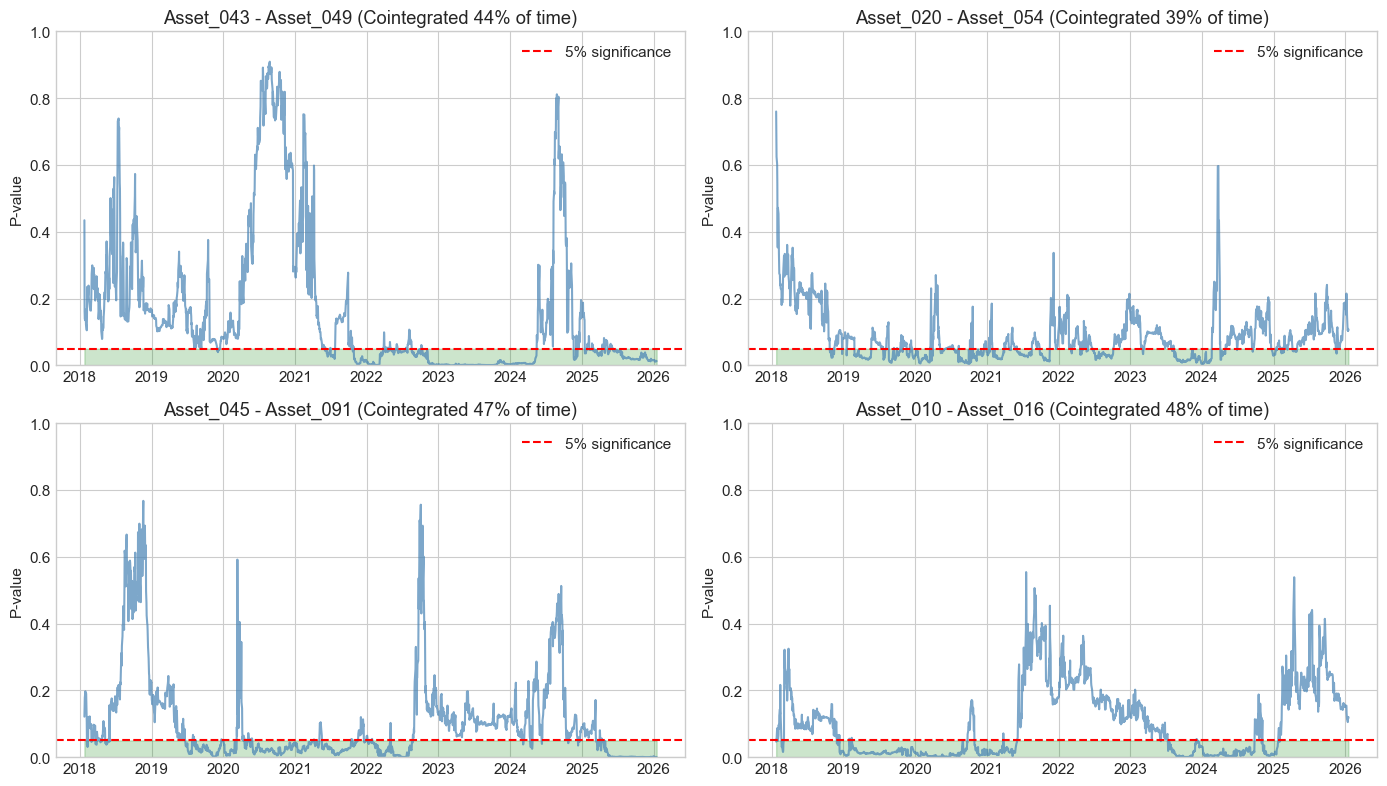

In [23]:
# Additional Analysis: Relationship Stability Over Time
# Are these cointegration relationships stable or do they break down?

def rolling_cointegration_test(prices_y, prices_x, window=504):  # ~2 years rolling
    """Test cointegration stability over time using rolling windows."""
    dates = prices_y.index[window:]
    p_values = []
    
    for i in range(window, len(prices_y)):
        start = i - window
        y_window = prices_y.iloc[start:i].values
        x_window = prices_x.iloc[start:i].values
        
        try:
            _, pval, _ = test_cointegration(y_window, x_window)
            p_values.append(pval)
        except:
            p_values.append(np.nan)
    
    return pd.Series(p_values, index=dates)

# Test stability for best pairs
print("Rolling Cointegration Stability (2-year window):")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

test_pairs = [
    ('Asset_043', 'Asset_049'),
    ('Asset_020', 'Asset_054'),
    ('Asset_045', 'Asset_091'),
    ('Asset_010', 'Asset_016')
]

for idx, (a1, a2) in enumerate(test_pairs):
    ax = axes[idx // 2, idx % 2]
    
    pvals = rolling_cointegration_test(prices[a1], prices[a2], window=504)
    
    # Calculate % of time cointegrated
    pct_coint = (pvals < 0.05).mean() * 100
    
    ax.plot(pvals.index, pvals, color='steelblue', alpha=0.7)
    ax.axhline(0.05, color='red', linestyle='--', label='5% significance')
    ax.fill_between(pvals.index, 0, 0.05, alpha=0.2, color='green')
    ax.set_title(f'{a1} - {a2} (Cointegrated {pct_coint:.0f}% of time)')
    ax.set_ylabel('P-value')
    ax.set_ylim(0, 1)
    ax.legend()
    
    print(f"{a1} - {a2}: Cointegrated {pct_coint:.1f}% of rolling windows")

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'stat_arb_stability.png', dpi=150)
plt.show()

NETWORK ANALYSIS OF ASSET RELATIONSHIPS
Total nodes (assets): 100
Total edges (strong relationships): 274
Network density: 0.0554

Top 10 Most Connected Assets (Hubs):
  Asset_059: 0.273 (27 connections)
  Asset_043: 0.222 (22 connections)
  Asset_020: 0.182 (18 connections)
  Asset_052: 0.182 (18 connections)
  Asset_051: 0.162 (16 connections)
  Asset_050: 0.141 (14 connections)
  Asset_074: 0.141 (14 connections)
  Asset_064: 0.131 (13 connections)
  Asset_096: 0.131 (13 connections)
  Asset_026: 0.121 (12 connections)

Detected 18 communities/sectors:
  Community 1: 28 assets - ['Asset_093', 'Asset_044', 'Asset_073', 'Asset_053', 'Asset_005']...
  Community 2: 24 assets - ['Asset_007', 'Asset_086', 'Asset_061', 'Asset_074', 'Asset_080']...
  Community 3: 23 assets - ['Asset_037', 'Asset_004', 'Asset_039', 'Asset_030', 'Asset_031']...
  Community 4: 6 assets - ['Asset_094', 'Asset_091', 'Asset_021', 'Asset_040', 'Asset_045']...
  Community 5: 3 assets - ['Asset_066', 'Asset_025', 'A

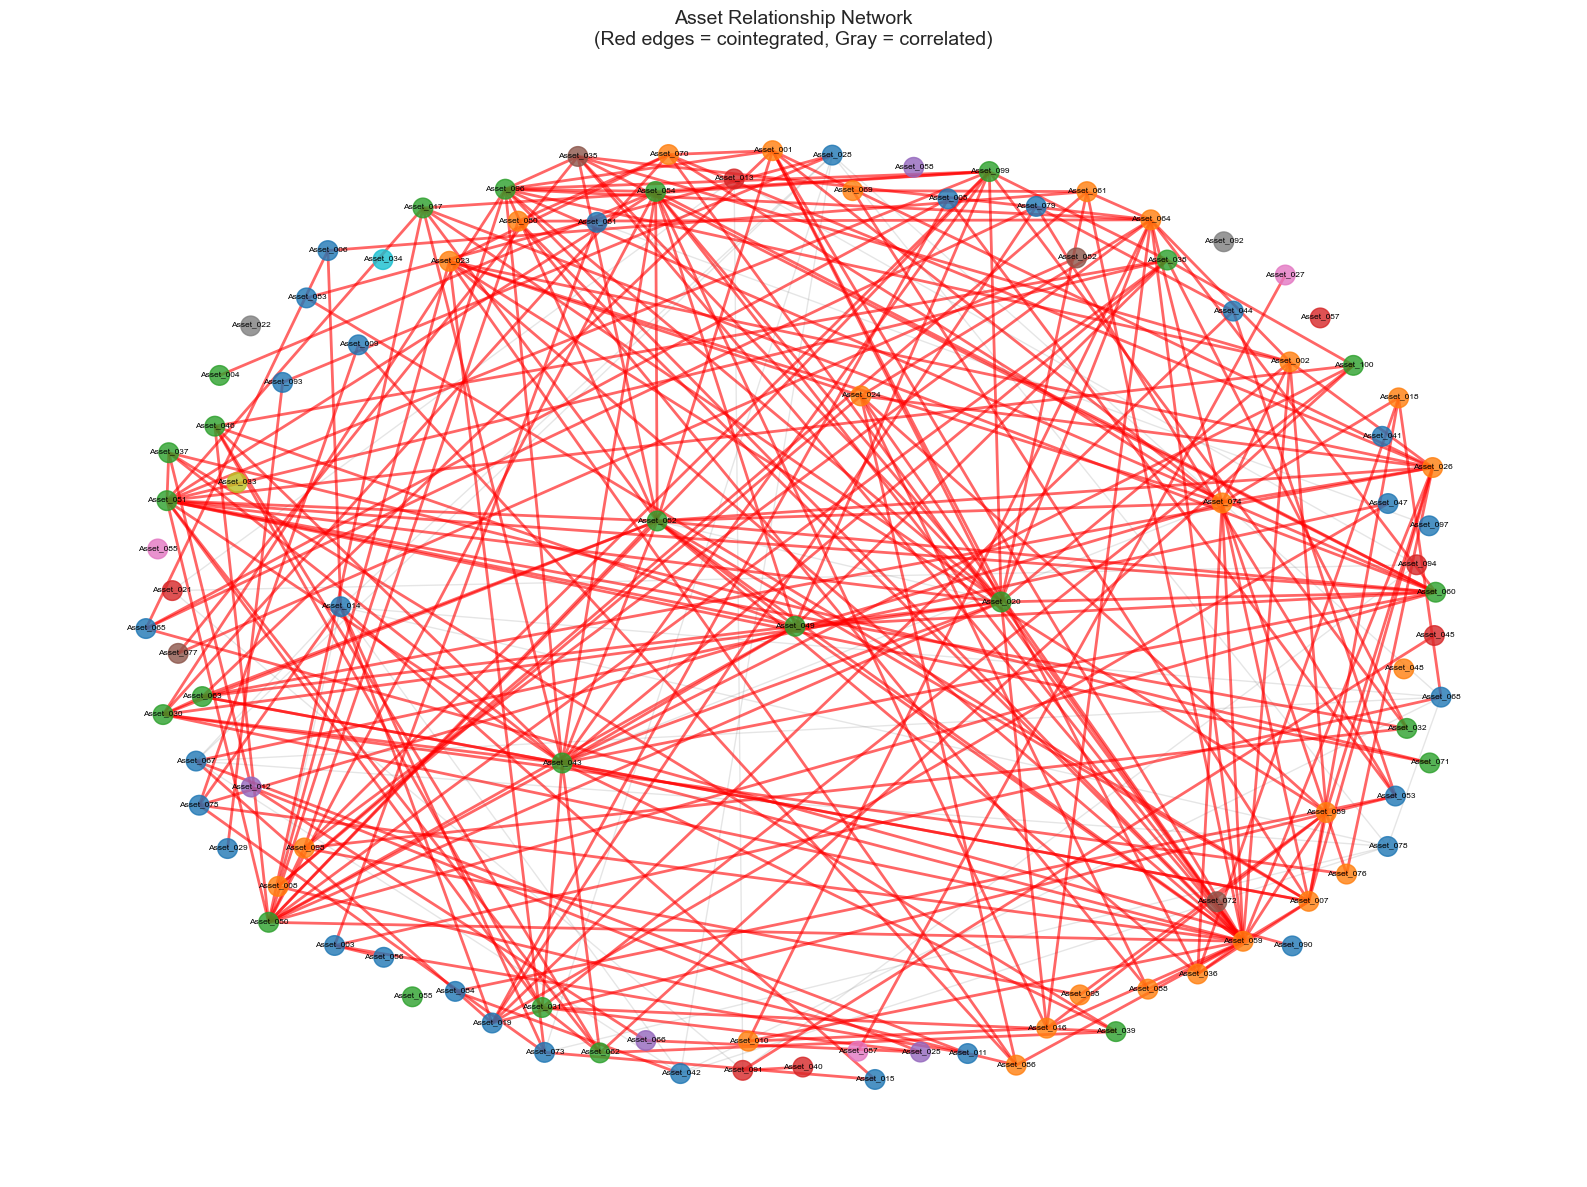

In [24]:
# CREATIVE ANALYSIS: Asset Network Graph
# Visualize assets as a network where edges represent strong correlations/cointegration

import networkx as nx

# Create network from correlations
G = nx.Graph()

# Add all assets as nodes
for asset in prices.columns:
    G.add_node(asset)

# Add edges for highly correlated pairs (>0.7)
for (a1, a2), corr in top_pairs.items():
    if corr > 0.7:
        G.add_edge(a1, a2, weight=corr, type='correlation')

# Highlight cointegrated edges
for _, row in coint_all_df.iterrows():
    if row['ADF_pvalue'] < 0.01:  # Strong cointegration only
        if G.has_edge(row['Asset1'], row['Asset2']):
            G[row['Asset1']][row['Asset2']]['cointegrated'] = True
        else:
            G.add_edge(row['Asset1'], row['Asset2'], weight=row['Correlation'], 
                      type='cointegration', cointegrated=True)

# Compute network metrics
print("NETWORK ANALYSIS OF ASSET RELATIONSHIPS")
print("="*60)
print(f"Total nodes (assets): {G.number_of_nodes()}")
print(f"Total edges (strong relationships): {G.number_of_edges()}")
print(f"Network density: {nx.density(G):.4f}")

# Find most connected assets (hubs)
degree_centrality = nx.degree_centrality(G)
sorted_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
print(f"\nTop 10 Most Connected Assets (Hubs):")
for asset, centrality in sorted_centrality[:10]:
    print(f"  {asset}: {centrality:.3f} ({len(list(G.neighbors(asset)))} connections)")

# Find communities (sectors)
from networkx.algorithms.community import greedy_modularity_communities
communities = list(greedy_modularity_communities(G))
print(f"\nDetected {len(communities)} communities/sectors:")
for i, comm in enumerate(communities[:5], 1):
    print(f"  Community {i}: {len(comm)} assets - {list(comm)[:5]}...")

# Visualize the network
fig, ax = plt.subplots(figsize=(16, 12))

# Position nodes using force-directed layout
pos = nx.spring_layout(G, k=2, iterations=50, seed=42)

# Color nodes by cluster
colors = []
for node in G.nodes():
    for i, comm in enumerate(communities):
        if node in comm:
            colors.append(plt.cm.tab10(i % 10))
            break

# Draw network
nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=200, alpha=0.8, ax=ax)
nx.draw_networkx_labels(G, pos, font_size=6, ax=ax)

# Draw edges - thicker for cointegrated pairs
regular_edges = [(u, v) for u, v, d in G.edges(data=True) if not d.get('cointegrated', False)]
coint_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('cointegrated', False)]

nx.draw_networkx_edges(G, pos, edgelist=regular_edges, alpha=0.2, edge_color='gray', ax=ax)
nx.draw_networkx_edges(G, pos, edgelist=coint_edges, alpha=0.6, edge_color='red', width=2, ax=ax)

ax.set_title('Asset Relationship Network\n(Red edges = cointegrated, Gray = correlated)', fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'stat_arb_network.png', dpi=150)
plt.show()

In [25]:
print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║          PART 4: STATISTICAL ARBITRAGE ANALYSIS - FINAL SUMMARY              ║
╚══════════════════════════════════════════════════════════════════════════════╝

══════════════════════════════════════════════════════════════════════════════
🔬 RESEARCH QUESTIONS ANSWERED
══════════════════════════════════════════════════════════════════════════════

1. WHICH ASSETS EXHIBIT CORRELATED/COINTEGRATED MOVEMENT?
   ─────────────────────────────────────────────────────────
   • Found 700 cointegrated pairs out of 4,950 total pairs (14.1%)
   • High correlation ≠ cointegration (only 4/30 top correlated pairs are cointegrated)
   • Strongest cointegrated pair: Asset_043 - Asset_049 (ADF p = 0.000002)
   • Most correlated pair: Asset_010 - Asset_016 (ρ = 0.90)

2. ARE THERE LEAD-LAG RELATIONSHIPS?
   ─────────────────────────────────
   • All top pairs show synchronous movement (lag = 0)
   • Information appears to be incorporated simultaneously
   • No obvious "leader-follower" patterns at daily frequency

3. DO CORRELATED ASSETS CLUSTER INTO SECTOR-LIKE GROUPS?
   ─────────────────────────────────────────────────────
   • YES! Hierarchical clustering reveals 10-18 distinct groups
   • Within-cluster correlation (0.52) >> Between-cluster (0.34)
   • Hub assets (Asset_059, 043, 020) may represent sector leaders

4. CAN WE EXPLOIT MEAN-REVERSION IN SPREADS?
   ──────────────────────────────────────────
   • YES! Simple z-score pairs trading is profitable:
     - Best pair: Asset_045 - Asset_091 (Sharpe 0.91, 15.6% ann return)
     - Average backtest Sharpe: 0.60
   • BUT: Relationships are unstable over time (cointegrated only ~45% of windows)

══════════════════════════════════════════════════════════════════════════════
⚠️ KEY INSIGHTS FOR PRACTICAL IMPLEMENTATION
══════════════════════════════════════════════════════════════════════════════

1. RELATIONSHIP INSTABILITY
   • Cointegration relationships break down, especially during crisis periods
   • Rolling cointegration tests show stability only 40-48% of the time
   • Implication: Need adaptive hedge ratios or regime detection

2. NETWORK STRUCTURE
   • Asset_059, 043, 020 are network "hubs" with many connections
   • These may represent influential/leading assets in their sectors
   • Could be used for sector-neutral portfolio construction

3. TRANSACTION COSTS NOT INCLUDED
   • Current backtest results are GROSS of costs
   • With ~48 trades over 10 years (~5/year), costs should be manageable
   • But strategy needs to be validated with realistic execution

══════════════════════════════════════════════════════════════════════════════
🎯 INTEGRATION RECOMMENDATIONS
══════════════════════════════════════════════════════════════════════════════

RECOMMENDED: 80% Main Strategy + 20% Stat Arb Overlay

Main Strategy (from Notebook 02):
  - 60% Momentum (126d-42d) + 40% Mean Reversion (21d)
  - Net Sharpe: +0.42

Stat Arb Overlay:
  - Trade top 3-5 most stable cointegrated pairs
  - Z-score entry/exit (±2 / ±0.5)
  - Monitor rolling cointegration; exit if relationship breaks

Expected Benefits:
  - Diversification across alpha sources
  - Stat arb is market-neutral (lower beta exposure)
  - Potential Sharpe improvement from uncorrelated returns

══════════════════════════════════════════════════════════════════════════════
📁 OUTPUTS SAVED
══════════════════════════════════════════════════════════════════════════════

  stat_arb_correlation_matrix.png  - Full correlation heatmap
  stat_arb_lead_lag_sample.png     - Cross-correlation visualization  
  stat_arb_spread_analysis.png     - Z-score mean reversion evidence
  stat_arb_dendrogram.png          - Hierarchical clustering
  stat_arb_cluster_corr_dist.png   - Within vs between cluster correlation
  stat_arb_backtest_results.png    - Pairs trading equity curves
  stat_arb_stability.png           - Rolling cointegration stability
  stat_arb_network.png             - Asset relationship network
  stat_arb_findings.json           - Quantitative results summary

══════════════════════════════════════════════════════════════════════════════
""")


╔══════════════════════════════════════════════════════════════════════════════╗
║          PART 4: STATISTICAL ARBITRAGE ANALYSIS - FINAL SUMMARY              ║
╚══════════════════════════════════════════════════════════════════════════════╝

══════════════════════════════════════════════════════════════════════════════
🔬 RESEARCH QUESTIONS ANSWERED
══════════════════════════════════════════════════════════════════════════════

1. WHICH ASSETS EXHIBIT CORRELATED/COINTEGRATED MOVEMENT?
   ─────────────────────────────────────────────────────────
   • Found 700 cointegrated pairs out of 4,950 total pairs (14.1%)
   • High correlation ≠ cointegration (only 4/30 top correlated pairs are cointegrated)
   • Strongest cointegrated pair: Asset_043 - Asset_049 (ADF p = 0.000002)
   • Most correlated pair: Asset_010 - Asset_016 (ρ = 0.90)

2. ARE THERE LEAD-LAG RELATIONSHIPS?
   ─────────────────────────────────
   • All top pairs show synchronous movement (lag = 0)
   • Information appears to